In [1]:
import os, copy
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
from matplotlib.colors import LogNorm

In [3]:
def plot_corr(df, X, Y, x_name=None, y_name=None, fig_title=None, out_path=None, fig_size=(5, 5), 
              x_lim=None, y_lim=None, text_y_pos1=None, text_y_pos2=None):
    
    plt.figure(figsize=fig_size, dpi=500)
    sns.set(style="whitegrid", font_scale=1.2)
    ax = sns.JointGrid(data=df, x=df[X].to_numpy(), y=df[Y].to_numpy(),
                       xlim=x_lim, ylim=y_lim, height=5, ratio=3)
    ax = ax.plot_joint(sns.regplot, x_jitter=False, y_jitter=False, 
                       scatter_kws={"alpha": 0.5, "edgecolor": "white"}, 
                       line_kws={"linewidth": 1})
    ax = ax.plot_marginals(sns.histplot, kde=True, linewidth=1)
    
    x_thres = 21.33 if X == "Score" else 0
    ax.refline(x=x_thres, color="r", alpha=.7)
    ax.ax_joint.text(x=23, y=max(df[Y])*1.1, 
                     s="threshold", color="r", fontstyle="italic", size=10)
    ax.refline(y=0, color="r", alpha=.7)
    
    ax.refline(y=np.mean(df[Y]), color="g")
    ax.ax_joint.text(x=3, y=np.mean(df[Y])*1.1, 
                     s="mean", color="g", fontstyle="italic", size=10)
    
    r, p = stats.pearsonr(df[X], df[Y], alternative="two-sided")
    
    p_txt = "p < .001" if p < .001 else "p = "+"{:.3f}".format(p).lstrip("0")
    p_color = "r" if p < .05 else "k"
    p_fw = "bold" if p < .05 else "normal"
    
    text_y_pos1 = min(df[Y]) if text_y_pos1 == None else text_y_pos1
    ax.ax_joint.text(x=3, y=text_y_pos1, 
                     s="r = {:.2f}, {:}".format(r, p_txt), 
                     fontstyle="italic", color=p_color, fontweight=p_fw)
    N = len(df)
    text_y_pos2 = max(df[Y]) if text_y_pos2 == None else text_y_pos2
    ax.ax_joint.text(x=45, y=text_y_pos2, 
                     s=f"N = {N}", color="gray", fontstyle="italic", size=12)
    
    ax.set_axis_labels(xlabel=x_name, ylabel=y_name, size=12)
    plt.tight_layout()
    
    if fig_title != None:
        plt.suptitle(fig_title, fontsize=14, x=.85, y=.85)
        # plt.title(fig_title, fontsize=20)
    
    if out_path is not None:
        plt.savefig(out_path, format="png", dpi=500)
        plt.close()
        plt.clf()
    
    return r, p

In [4]:
def plot_heatmap(mat, x_labs, y_labs, fig_title=None, out_path=None, fig_size=(10, 20), 
                 cmap=["coolwarm", "Spectral_r"][0], cmin=-1, cmax=1, cbar_title=None,
                 norm=None, show_value=True, fmt=".3f"):
        
    plt.figure(figsize=fig_size, dpi=500)
    sns.set(style="white", font_scale=1.2)
    ax = sns.heatmap(mat, # square=True, 
                     annot=show_value, fmt=fmt, linewidth=.5, 
                     cmap=cmap, vmin=cmin, vmax=cmax, norm=norm, 
                     cbar_kws={"shrink": 0.5, 'label': cbar_title})
    
#     ax.xaxis.set_major_locator(mpl.ticker.FixedLocator(np.arange(0, len(x_labs))))
#     ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(np.arange(0, len(y_labs))))
#     ax.set_xticklabels(x_labs, rotation=90, fontsize=20)
    ax.set_xticklabels(x_labs, rotation=0, fontsize=20)
    ax.set_yticklabels(y_labs, rotation=0, fontsize=20)
    plt.tight_layout()
    
    if fig_title != None:
        # ax.set_title(fig_title, fontsize=20)
        plt.suptitle(fig_title, fontsize=20, x=.95, y=.95, horizontalalignment="right")
    
    if out_path is not None:
        plt.savefig(out_path, format="png")
        plt.close()
        plt.clf()

In [5]:
def remove_outlier_indices(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    not_outliers = ~ ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))
    
    return not_outliers

# Correlation plots

In [6]:
TO_DO = {
    1: "PyMVPA", 
    2: "UnivariateActivity",
    3: "both"
}[2]

ap_UniV = "runs_MNI_3ord_v6_REML"

ap_MVPA = "ap-runs_v5"

MVPA_stim_type = ["tpl_sorted", "triplets"][1]
MVPA_run_groupby = ["each", "binded"][1]

In [7]:
top_dir = "." 
behav_dir = os.path.join(top_dir, "Familiarity_test_performance")

behav_fn = "subj_score_LN.tsv" 
behav_table = pd.read_csv(os.path.join(behav_dir, behav_fn), sep="\t", header=0)

In [8]:
learner_only = 0
threshold = [27, 21.33][0]

remove_outlier = 0

gfunc = ["", "_gfunc"][0]

roi_list = [
    "Pre_Central",                                                                          # Frontal 
    "Inf_Pari", "Para_Central", "Post_Central", "Pre_Cuneus", "Sup_Pari", "Supra_Marginal", # Parietal
    "Isth_Cingulate", "Insula", "Post_Cingulate",                                           # Limbic
    "Caudate", "Putamen",                                                                   # Striatum
    "Hipp-Sub", "Hipp-CA1", "Hipp-CA2+3", "Hipp-DG+CA4", "Hippocampus",                     # Hippocampus
    "PHC", "PRC", "ERC", "MTL",                                                             # MTL
    "Inf_Temp", "Mid_Temp", "Sup_Temp", "Trans_Temp",                                       # Temporal
    "Peri_Calcarine", "Fusiform", "Cuneus", "High-Vis", "V3", "V2", "V1", "Lingual",        # Occipital   
    "CBM"
]

FIG_HIGHT = 12
FIG_WIDTH = 12 

In [9]:
roi_list = [
    "lh-PHC", "rh-PHC", "lh-PRC", "rh-PRC", "lh-ERC", "rh-ERC", 
    "lh-Hipp-CA1", "rh-Hipp-CA1", "lh-Hipp-CA2+3", "rh-Hipp-CA2+3", 
    "lh-Hipp-DG+CA4", "rh-Hipp-DG+CA4", "lh-Hipp-Sub", "rh-Hipp-Sub", 
    "lh-Caudate", "rh-Caudate", "lh-Putamen", "rh-Putamen"
]

### Setup and load dataframe:

In [10]:
if (TO_DO == "PyMVPA") or (TO_DO == "both"):
    
    data_dir = os.path.join(top_dir, "PyMVPA", "odd_even_trials_similarity", ap_MVPA)           ###
    out_top = os.path.join(data_dir, "Corr_with_behav", f"{MVPA_stim_type}_{MVPA_run_groupby}") ###

    data_fn = f"allROI_allRlist_allCond_allSubj_{MVPA_stim_type}_{MVPA_run_groupby}.csv"        ###
    
    data_table = pd.read_csv(os.path.join(data_dir, data_fn), sep=",", header=0)
    data_table.rename(columns = {"Runs": "Run"})
#     data_table = data_table.replace("All", "1+2+3")
    
    qV, fig_y_name, fig_y_lim = "Similarity", "Pattern Similarity", (-1, 1)
    qV_2, fig_x_name, fig_x_lim = "Score", "Familiarity score", (0, 60)

In [11]:
if TO_DO == "both":
    
    data_table_2 = copy.deepcopy(data_table)

In [12]:
if (TO_DO == "UnivariateActivity") or (TO_DO == "both"):

    data_dir = os.path.join(top_dir, f"ROIstats{gfunc}", ap_UniV)                  ###
    folder = "Corr_with_behav (gfunc)" if gfunc == "_gfunc" else "Corr_with_behav" ###
    out_top = os.path.join(top_dir, "ROI_analysis", ap_UniV, folder) 
    
    data_fn = "maskave.all_ROI_Run_Cond.csv"                                       ###
    
    data_table = pd.read_csv(os.path.join(data_dir, data_fn), sep=",", header=0)
    data_table["Run"] = data_table["Run"].map(lambda x: "run-{:02}".format(x))
    data_table["Y"] = data_table["Y"] *100
    
#     data_table = data_table.replace("1+2+3", "All")
#     data_table = data_table.replace("any.stim", "All")

    cond_list =  ["Fst", "Snd", "Trd"]
    data_table = data_table.query("Cond in @cond_list")
    
    qV, fig_y_name, fig_y_lim = "Y", "Intensity (×100)", None
    qV_2, fig_x_name, fig_x_lim = "Score", "Familiarity score", (0, 60)

In [13]:
if TO_DO == "both":
    
    out_top = os.path.join(top_dir, "Intensity_x_Stability") ###
    
    data_table = data_table.merge(data_table_2, on=["Subj", "ROI", "Run", "Cond"])
    
    qV, fig_y_name, fig_y_lim = "Y", "Intensity (×100)", None
    qV_2, fig_x_name, fig_x_lim = "Similarity", "Pattern similarity", None

In [14]:
data_table = data_table.merge(behav_table, how="left", on="Subj")
data_table["Score"] = data_table["Score"] *60

cond_list = list(set(data_table["Cond"]))
run_list = sorted(list(set(data_table["Run"])))

out_dir = os.path.join(out_top, f"{len(roi_list)}_ROIs")

if learner_only: 
    out_dir = out_dir + " (learner_only)"

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [15]:
list(data_table.columns)

['Subj', 'Y', 'ROI', 'Run', 'Cond', 'Design', 'Score', 'Group']

In [16]:
# data_table.query('ROI == @roi_list[14] & Cond == @cond & Run == @run').head()

In [17]:
# roi_list.index('lh-Caudate')

## Correlation: compute (main) and plot (optional)

In [18]:
## Jointed regression + histogram plots

PLOT_ME = 0 

for cond in cond_list:
    corr_R, corr_pval = {}, {}

    for run in run_list:
        corr_R[run], corr_pval[run] = {}, {} 

        for roi in roi_list:
            # print(roi)
            sub_df = data_table.query('ROI == @roi & Cond == @cond & Run == @run')
            
            if learner_only:
                sub_df = sub_df.query(('Score > @threshold'))
                
            if remove_outlier:
                sub_df = sub_df[remove_outlier_indices(sub_df, qV)]
                sub_df = sub_df[remove_outlier_indices(sub_df, qV_2)]
                
                out_dir = out_dir + " (outlier removed)"
                if not os.path.exists(out_dir):
                    os.makedirs(out_dir)     

            if PLOT_ME:
                fig_name = f"{roi}_{run}.png"
                
                fig_folder = os.path.join(out_dir, cond)
                if not os.path.exists(fig_folder):
                    os.makedirs(fig_folder)                
                
                r, p = plot_corr(sub_df[[qV, qV_2]], qV_2, qV,
                                 fig_title = f"{roi}\n{run}", 
                                 out_path = os.path.join(fig_folder, fig_name), 
                                 x_name=fig_x_name, x_lim=fig_x_lim, 
                                 y_name=fig_y_name, y_lim=fig_y_lim)
            else:
                r, p = stats.pearsonr(sub_df[qV_2], sub_df[qV], alternative="two-sided")
                
            corr_R[run][roi], corr_pval[run][roi] = r, p

    ## save to files:
    for corr_dict, typ in zip([corr_R, corr_pval], ["R", "pVal"]):
        
        file_name = f"{typ}_cormat_{cond}.csv"
        mat = pd.DataFrame(corr_dict)
        mat.to_csv(os.path.join(out_dir, file_name))

## Plot heatmaps

### for R values:

In [19]:
for cond in cond_list:
    
    file_name = f"R_cormat_{cond}.csv"
    file_path = os.path.join(out_dir, file_name)
    mat = pd.read_csv(file_path, header=0, index_col=0)    
    
    fig_dir = os.path.join(out_dir, "plot_with_Python (Heatmap)")
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    fig_path = os.path.join(fig_dir, file_name.replace(".csv", ".png"))
    
    plot_heatmap(mat, y_labs=roi_list, 
                 x_labs=[ R.replace("run-", "") for R in run_list ], 
                 fig_title=cond, out_path=fig_path, 
                 cmap="coolwarm", cmin=-1, cmax=1, cbar_title="R values",
                 fig_size=(FIG_WIDTH, FIG_HIGHT))

<Figure size 432x288 with 0 Axes>

### for p-values:

In [20]:
 for cond in cond_list:
    
    file_name = f"pVal_cormat_{cond}.csv"
    file_path = os.path.join(out_dir, file_name)
    mat = pd.read_csv(file_path, header=0, index_col=0)  
    
    fig_dir = os.path.join(out_dir, "plot_with_Python (Heatmap)")
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    fig_path = os.path.join(fig_dir, file_name.replace(".csv", ".png"))   
    
    plot_heatmap(mat, y_labs=roi_list, 
                 x_labs=[ R.replace("run-", "") for R in run_list ], 
                 fig_title=cond, out_path=fig_path, 
                 cmap="hot", cmin=0, cmax=1, norm=LogNorm(), cbar_title="p-values",
                 fig_size=(FIG_WIDTH, FIG_HIGHT))

<Figure size 432x288 with 0 Axes>

## Plot specified correlation

.\ROI_analysis\runs_MNI_3ord_v6_REML\Corr_with_behav\18_ROIs\plot_with_Python (Regression)\Snd_Hippocampus_run-04.jpg


(0.39391781730882425, 0.01585188084534749)

<Figure size 2500x2500 with 0 Axes>

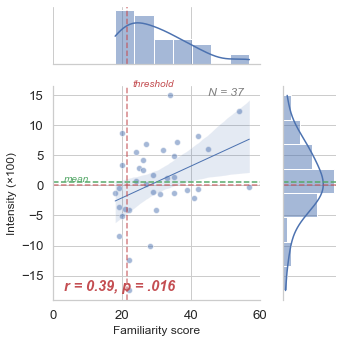

In [21]:
# qV = ["Y", "Similarity", "Score"][0]
# qV_2 = ["Y", "Similarity", "Score"][2]

cond = ["All", "Fst", "Snd", "Trd"][2]
roi = ["High-Vis", "Hippocampus"][1]
run = "run-04"

sub_df = data_table.query(('ROI == @roi & Cond == @cond & Run == @run'))
fig_name = f"{cond}_{roi}_{run}.jpg"

if remove_outlier:
    sub_df = sub_df[remove_outlier_indices(sub_df, qV)]
    sub_df = sub_df[remove_outlier_indices(sub_df, qV_2)]
    fig_name = f"{cond}_{roi}_{run} (outlier removed).jpg"
    
fig_dir = os.path.join(out_dir, "plot_with_Python (Regression)")
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
    
fig_save = os.path.join(fig_dir, fig_name)
print(fig_save)

# r, p = 
plot_corr(sub_df, qV_2, qV, 
#           fig_title=fig_title, 
#           out_path=fig_save, 
          x_name=fig_x_name, x_lim=fig_x_lim, 
          y_name=fig_y_name, y_lim=fig_y_lim)

## Print out (what did I do)

In [22]:
if TO_DO == "PyMVPA":
    do_what = "Pattern Similarity & Familiarity Score"
    folder_1 = f"...\\odd_even_trials_similarity\\{ap_MVPA}"
    folder_2 = f".\\Familiarity_test_performance\\{behav_fn}"
    
elif TO_DO == "UnivariateActivity":
    do_what = "Univariate Activity & Familiarity Score"
#     folder_1 = f".\\Group_analysis\\ROIstats\\{ap_UniV}\\Corr_with_behav"
    folder_1 = out_dir
    folder_2 = f".\\Familiarity_test_performance\\{behav_fn}"
    
elif TO_DO == "both":
    do_what = "Pattern Similarity & Univariate Activity"
    folder_1 = f"...\\odd_even_trials_similarity\\{ap_MVPA}\\*_{stim_type}_{run_groupby}.csv"
    folder_2 = out_dir
#     folder_2 = f".\\Group_analysis\\ROIstats\\{ap_UniV}\\Corr_with_behav"

print(f'''+++++ Done +++++

+ Correlation   : {do_what}
++ data_dir_1   : {folder_1}
++ data_dir_2   : {folder_2}

+ Name(Conds)   : {cond_list} 
+ Name(Runs)    : {run_list}
+ Number(ROI)   : {len(roi_list)}
    
+ Remove outlier: {["False", "True"][remove_outlier]}
+ Learner only  : {["False", "True"][learner_only]} (threshold = {threshold})

+ Figure size   : {FIG_WIDTH} x {FIG_HIGHT}
+ Output at     : "{out_dir}"  
''')

+++++ Done +++++

+ Correlation   : Univariate Activity & Familiarity Score
++ data_dir_1   : .\ROI_analysis\runs_MNI_3ord_v6_REML\Corr_with_behav\18_ROIs
++ data_dir_2   : .\Familiarity_test_performance\subj_score_LN.tsv

+ Name(Conds)   : ['Fst', 'Snd', 'Trd'] 
+ Name(Runs)    : ['run-02', 'run-03', 'run-04', 'run-05', 'run-06', 'run-07', 'run-08', 'run-09']
+ Number(ROI)   : 18
    
+ Remove outlier: False
+ Learner only  : False (threshold = 27)

+ Figure size   : 12 x 12
+ Output at     : ".\ROI_analysis\runs_MNI_3ord_v6_REML\Corr_with_behav\18_ROIs"  



## Additional try
### 1) Correlate MEAN Intensity (across runs) with behav score:

In [23]:
## Heatmap (make dataframe):

new_df_r, new_df_p = {}, {}
new_cond_list = ["Fst", "Snd", "Trd"]
# new_cond_list = ["Fst", "Snd", "Trd", "All"]

for cond in new_cond_list:
    new_df_r[cond], new_df_p[cond] = {}, {}
    
    for roi in roi_list:
        subj_run_mean = (data_table
                         .query(('ROI == @roi & Cond == @cond'))
                         .pivot(index="Subj", columns="Run", values="Y")
                         .mean(axis=1))
        
        temp_df = (pd.DataFrame(subj_run_mean, columns=["Y"])
                   .merge(behav_table, how="left", on="Subj"))
        
        r, p = stats.pearsonr(temp_df["Score"], temp_df["Y"], alternative="two-sided")
        new_df_r[cond][roi], new_df_p[cond][roi] = r, p

In [24]:
## Heatmap (R values):

fig_name = f"R ({len(roi_list)}).png"

fig_dir = os.path.join(out_dir, "plot_with_Python (Heatmap, mean across runs)")
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

plot_heatmap(pd.DataFrame(new_df_r), 
             y_labs=roi_list, 
             x_labs=new_cond_list, 
#              fig_title="MEAN across runs", 
             out_path=os.path.join(fig_dir, fig_name), 
             cmap="coolwarm", cmin=-1, cmax=1, cbar_title="R values",
             fig_size=(6, 12))

<Figure size 432x288 with 0 Axes>

In [25]:
## Heatmap (p values):

fig_name = f"pVal ({len(roi_list)}).png"

fig_dir = os.path.join(out_dir, "plot_with_Python (Heatmap, mean across runs)")
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

plot_heatmap(pd.DataFrame(new_df_p), 
             y_labs=roi_list, 
             x_labs=new_cond_list, 
#              fig_title="MEAN across runs", 
             out_path=os.path.join(fig_dir, fig_name), 
             cmap="hot", cmin=0, cmax=1, norm=LogNorm(), cbar_title="p-values",
             fig_size=(6, 12))

<Figure size 432x288 with 0 Axes>

Snd_Hippocampus_run-MEAN.jpg


(0.0030636372668501966, 0.9856422189339137)

<Figure size 2500x2500 with 0 Axes>

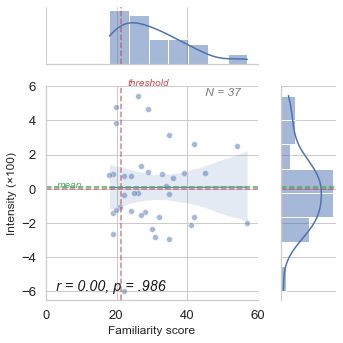

In [26]:
## Regression plot:

cond = ["Fst", "Snd", "Trd", "All"][1]
roi = ["High-Vis", "Hippocampus"][1]

subj_mean_Y = (data_table
               .query(('ROI == @roi & Cond == @cond'))
               .pivot(index="Subj", columns="Run", values="Y")
               .mean(axis=1))

new_df = (pd.DataFrame(subj_mean_Y, columns=["Y"])
          .merge(behav_table, how="left", on="Subj"))
new_df["Score"] = new_df["Score"] *60

fig_name = f"{cond}_{roi}_run-MEAN.jpg"
print(fig_name)

fig_dir = os.path.join(out_dir, "plot_with_Python (Regression)")
fig_save = os.path.join(fig_dir, fig_name)

# r, p = 
plot_corr(new_df, "Score", "Y",
#           fig_title=fig_title, 
#           out_path=fig_save, 
          x_name=fig_x_name, x_lim=fig_x_lim, 
          y_name=fig_y_name, y_lim=fig_y_lim)

### 2) Correlate Intensity DIFF (between runs OR conds) with behav score:

In [27]:
# ## between runs:

# cond = ["All", "Fst", "Snd", "Trd"][1]
# roi = ["High-Vis", "Hippocampus"][1]
# runs_compare = ["run-02", "run-03", "run-04"] ###

# sub_df = data_table.query(('ROI == @roi & '+
#                            'Cond == @cond & '+
#                            'Run in @runs_compare'))

# # sub_df = sub_df[remove_outlier_indices(sub_df, "Y")]
# # sub_df = sub_df[remove_outlier_indices(sub_df, "Score")]

# runs_2comp_Y = (sub_df[["Subj", "Run", "Y"]]
#                 .pivot(index="Subj", columns="Run", values= "Y"))

# sub_df = (pd.DataFrame({"Y_Run_4-2": runs_2comp_Y["run-04"] - runs_2comp_Y["run-02"], 
#                         "Y_Run_4-3": runs_2comp_Y["run-04"] - runs_2comp_Y["run-03"]})
#           .merge(behav_table[["Subj", "Score"]], on="Subj")
#           .dropna())

# sub_df["Score"] = sub_df["Score"] *60

In [28]:
# plot_corr(sub_df, X="Score", Y=["Y_Run_4-2", "Y_Run_4-3"][0],
#           fig_title="{:}\n{:}\n{:}".format(roi, cond, qV), 
#           # out_path=os.path.join(), 
#           x_name="Familiarity score", x_lim=(0, 60), 
#           y_name="Intensity change (×100)")

In [29]:
## between conds:

cond_comp = ["Fst", "Trd"]
qV = "Fst_vs_Trd"

roi = ["High-Vis", "Hippocampus"][1]
run = "run-05"

sub_df = data_table.query(('ROI == @roi & '+
                           'Cond in @cond_comp & '+
                           'Run == @run'))

# sub_df = sub_df[remove_outlier_indices(sub_df, "Y")]
# sub_df = sub_df[remove_outlier_indices(sub_df, "Score")]

conds_2comp_Y = (sub_df[["Subj", "Cond", "Y"]]
                .pivot(index="Subj", columns="Cond", values= "Y"))

sub_df = (pd.DataFrame({"Fst_vs_Trd": conds_2comp_Y["Fst"] - conds_2comp_Y["Trd"]})
          .merge(behav_table[["Subj", "Score"]], on="Subj")
          .dropna())

sub_df["Score"] = sub_df["Score"] *60

(-0.13754170694027507, 0.41691385638781386)

<Figure size 2500x2500 with 0 Axes>

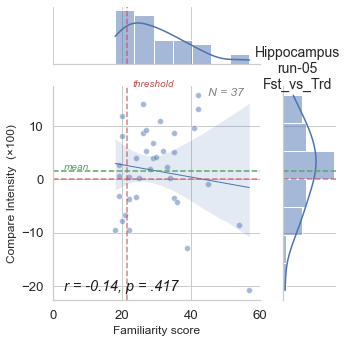

In [30]:
plot_corr(sub_df, X="Score", Y="Fst_vs_Trd",
          fig_title="{:}\n{:}\n{:}".format(roi, run, qV), 
          # out_path=os.path.join(), 
          x_name="Familiarity score", x_lim=(0, 60), 
          y_name="Compare Intensity  (×100)")

### #) Temp: Print out jigg_task performance 

In [31]:
# ## per-subject & per-run & overall mean hit rate

# top_dir = ".." # os.path.join("")
# vsl_task_dir = os.path.join(top_dir, "my_VSL")
# log_summ_file = os.path.join(vsl_task_dir, "logs", "jigg_task_perf_all.xlsx")

# subjList = list(pd.read_csv('subjList.txt', header=None)[0])
# subj_list = [ "{:03d}".format(int(subj.replace("sub-", ""))) for subj in subjList ]

# run_list = [ "RUN_{:}".format(x) for x in range(1, 11) ]

# log_summ = {}
# HitRate_perSubj_acrossRuns = {}
# HitRate_perRun_acrossSubjs = {}

# for subj in subj_list:
#     log_summ[subj] = pd.read_excel(log_summ_file, sheet_name=subj, 
#                                    engine="openpyxl", index_col=0)
#     HitRate_perSubj_acrossRuns[subj] = log_summ[subj].mean()["Hit_mean"]

# for run in run_list:
#     HitRate_list = [ log_summ[subj].T[run]["Hit_mean"] for subj in subj_list ]
#     HitRate_perRun_acrossSubjs[run] = np.array(HitRate_list).mean()

# HitRate_perRun_list = list(HitRate_perRun_acrossSubjs.values())
# HitRate_perSubj_list = list(HitRate_perSubj_acrossRuns.values())

# print("# Overall mean hit rate:", round(np.array(HitRate_perRun_list).mean(), 3))
# print("# SD of per-run hit rate:", round(np.array(HitRate_perRun_list).std(), 3))
# print("# SD of per-subj hit rate:", round(np.array(HitRate_perSubj_list).std(), 3))